In [1]:
"""
RONDA 1 - SCRIPT 1: Descarga y Limpieza del Dataset
====================================================

Propósito:
- Descargar Fashion Product Images Dataset desde Kaggle
- Validar integridad de imágenes y metadatos
- Limpiar datos (eliminar NaN, productos sin imagen, etc.)
- Guardar dataset limpio

Uso:
  - Google Colab / Kaggle Notebooks
  - GPU: No necesaria
  - Tiempo estimado: 5-10 minutos

Outputs:
  - df_clean.csv: Dataset limpio con metadatos
  - image_files_valid.txt: Lista de archivos de imagen válidos
  - cleaning_report.txt: Reporte de limpieza

Autor: similarPic Team
Fecha: 2025-11
"""

import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image, UnidentifiedImageError
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# ============================================
# CONFIGURACIÓN
# ============================================

# Detectar entorno de ejecución
IS_KAGGLE = os.path.exists('/kaggle/input')
IS_COLAB = 'COLAB_GPU' in os.environ

print("=" * 60)
print("  RONDA 1 - DESCARGA Y LIMPIEZA DEL DATASET")
print("=" * 60)
print(f"\nEntorno detectado: {'Kaggle' if IS_KAGGLE else 'Colab' if IS_COLAB else 'Local'}")

# ============================================
# 1. DESCARGAR DATASET
# ============================================

print("\n[1/5] Descargando dataset desde Kaggle...")

try:
    import kagglehub
except ImportError:
    print("⚠️ kagglehub no instalado. Instalando...")
    os.system("pip install kagglehub --quiet")
    import kagglehub

# Descargar dataset
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")
print(f"✅ Dataset descargado en: {path}")

# Detectar carpeta raíz
base_path = Path(path) / "fashion-dataset"
if not base_path.exists():
    base_path = Path(path)

print(f"📂 Carpeta base: {base_path}")
print(f"📁 Contenido: {[f.name for f in base_path.iterdir()][:10]}")

# Rutas importantes
images_path = base_path / "images"
styles_csv = base_path / "styles.csv"
images_csv = base_path / "images.csv"

# Verificar existencia
assert images_path.exists(), f"❌ No se encontró carpeta de imágenes en {images_path}"
assert styles_csv.exists(), f"❌ No se encontró styles.csv en {styles_csv}"

print(f"\n✅ Rutas configuradas:")
print(f"  - Imágenes: {images_path}")
print(f"  - Metadatos: {styles_csv}")

# ============================================
# 2. CARGAR METADATOS
# ============================================

print("\n[2/5] Cargando metadatos (styles.csv)...")

df = pd.read_csv(styles_csv, on_bad_lines='skip')
print(f"✅ CSV cargado: {len(df):,} filas, {df.shape[1]} columnas")
print(f"📊 Columnas: {df.columns.tolist()}")

# Información básica
print(f"\n🔍 Información del dataset:")
print(f"  - Productos: {len(df):,}")
print(f"  - Géneros: {df['gender'].nunique()} → {df['gender'].unique().tolist()}")
print(f"  - Categorías principales: {df['masterCategory'].nunique()}")
print(f"  - Tipos de artículo: {df['articleType'].nunique()}")

# ============================================
# 3. VALIDAR INTEGRIDAD IMAGEN-METADATA
# ============================================

print("\n[3/5] Validando integridad imagen-metadata...")

# Obtener lista de imágenes
valid_extensions = {'.jpg', '.jpeg', '.png'}
image_files = [
    f.name for f in images_path.iterdir()
    if f.suffix.lower() in valid_extensions
]
print(f"🖼️ Imágenes encontradas: {len(image_files):,}")

# Extraer IDs
df['id'] = df['id'].astype(str)
csv_ids = set(df['id'])
img_ids = {Path(f).stem for f in image_files}

# Comparar
only_in_csv = csv_ids - img_ids
only_in_imgs = img_ids - csv_ids
both = csv_ids & img_ids

print(f"\n📊 Análisis de coincidencias:")
print(f"  ✅ Coincidencias (CSV ∩ Imágenes): {len(both):,}")
print(f"  ❌ Solo en CSV (sin imagen): {len(only_in_csv):,}")
print(f"  ⚠️ Solo en imágenes (sin metadata): {len(only_in_imgs):,}")

if len(only_in_csv) > 0:
    print(f"\n  Ejemplos de IDs sin imagen: {list(only_in_csv)[:5]}")
if len(only_in_imgs) > 0:
    print(f"  Ejemplos de imágenes sin metadata: {list(only_in_imgs)[:5]}")

# Filtrar DataFrame: solo productos con imagen
df_with_image = df[df['id'].isin(both)].copy()
print(f"\n✅ Productos con imagen válida: {len(df_with_image):,}")

# ============================================
# 4. DETECTAR IMÁGENES CORRUPTAS
# ============================================

print("\n[4/5] Verificando integridad de imágenes...")

corrupted_images = []
valid_images = []

print("Analizando imágenes (puede tomar unos minutos)...")
for img_file in tqdm(image_files[:len(image_files)], desc="Verificando imágenes"):
    img_path = images_path / img_file
    img_id = Path(img_file).stem

    # Solo verificar si tiene metadata
    if img_id not in both:
        continue

    try:
        with Image.open(img_path) as img:
            img.verify()  # Verificar integridad
        valid_images.append(img_id)
    except (UnidentifiedImageError, OSError, Exception) as e:
        corrupted_images.append((img_id, str(e)))

print(f"\n✅ Imágenes válidas: {len(valid_images):,}")
print(f"❌ Imágenes corruptas: {len(corrupted_images):,}")

if len(corrupted_images) > 0:
    print(f"\n⚠️ Imágenes con problemas:")
    for img_id, error in corrupted_images[:10]:
        print(f"  - {img_id}: {error}")

# Filtrar productos con imágenes válidas
valid_ids_set = set(valid_images)
df_valid_images = df_with_image[df_with_image['id'].isin(valid_ids_set)].copy()

print(f"\n✅ Productos con imágenes válidas: {len(df_valid_images):,}")

# ============================================
# 5. LIMPIEZA DE DATOS
# ============================================

print("\n[5/5] Limpiando datos...")

# Análisis de valores nulos
print("\n🔍 Valores nulos por columna:")
null_counts = df_valid_images.isnull().sum()
print(null_counts[null_counts > 0])

# Eliminar filas con NaN en columnas críticas
critical_cols = ['id', 'gender', 'masterCategory', 'subCategory', 'articleType']
df_clean = df_valid_images.dropna(subset=critical_cols).copy()

print(f"\n✅ Filas después de eliminar NaN en columnas críticas: {len(df_clean):,}")

# Opcional: Rellenar NaN en columnas no críticas
df_clean['baseColour'] = df_clean['baseColour'].fillna('Unknown')
df_clean['season'] = df_clean['season'].fillna('All')
df_clean['usage'] = df_clean['usage'].fillna('General')
df_clean['year'] = df_clean['year'].fillna(2015)  # Año promedio

print(f"📝 NaN restantes: {df_clean.isnull().sum().sum()}")

# Normalizar nombres de categorías
df_clean['gender'] = df_clean['gender'].str.strip()
df_clean['masterCategory'] = df_clean['masterCategory'].str.strip()
df_clean['articleType'] = df_clean['articleType'].str.strip()

# Eliminar duplicados por ID (por si acaso)
df_clean = df_clean.drop_duplicates(subset=['id']).reset_index(drop=True)

print(f"\n✅ Dataset final limpio: {len(df_clean):,} productos")

# ============================================
# 6. GUARDAR RESULTADOS
# ============================================

print("\n[6/6] Guardando resultados...")

# Crear carpeta de salida
if IS_KAGGLE:
    output_dir = Path('/kaggle/working')
elif IS_COLAB:
    output_dir = Path('/content/fashion_processed')
else:
    output_dir = Path('./data/processed')

output_dir.mkdir(parents=True, exist_ok=True)

# Guardar CSV limpio
csv_output = output_dir / "df_clean.csv"
df_clean.to_csv(csv_output, index=False)
print(f"✅ CSV limpio guardado: {csv_output}")

# Guardar lista de imágenes válidas
valid_img_list = output_dir / "image_files_valid.txt"
with open(valid_img_list, 'w') as f:
    for img_id in sorted(df_clean['id'].tolist()):
        f.write(f"{img_id}.jpg\n")
print(f"✅ Lista de imágenes guardada: {valid_img_list}")

# Guardar reporte de limpieza
report_path = output_dir / "cleaning_report.txt"
with open(report_path, 'w') as f:
    f.write("=" * 60 + "\n")
    f.write("  REPORTE DE LIMPIEZA DEL DATASET\n")
    f.write("=" * 60 + "\n\n")

    f.write("1. DATASET ORIGINAL\n")
    f.write(f"   - Total filas CSV: {len(df):,}\n")
    f.write(f"   - Total imágenes: {len(image_files):,}\n\n")

    f.write("2. VALIDACIÓN DE INTEGRIDAD\n")
    f.write(f"   - Coincidencias CSV-Imágenes: {len(both):,}\n")
    f.write(f"   - Solo en CSV (descartados): {len(only_in_csv):,}\n")
    f.write(f"   - Solo en imágenes (descartados): {len(only_in_imgs):,}\n\n")

    f.write("3. DETECCIÓN DE IMÁGENES CORRUPTAS\n")
    f.write(f"   - Imágenes válidas: {len(valid_images):,}\n")
    f.write(f"   - Imágenes corruptas: {len(corrupted_images):,}\n\n")

    f.write("4. LIMPIEZA DE DATOS\n")
    f.write(f"   - Productos con imagen válida: {len(df_valid_images):,}\n")
    f.write(f"   - Eliminados por NaN: {len(df_valid_images) - len(df_clean):,}\n")
    f.write(f"   - Dataset final limpio: {len(df_clean):,}\n\n")

    f.write("5. DISTRIBUCIÓN FINAL\n")
    f.write(f"   - Géneros únicos: {df_clean['gender'].nunique()}\n")
    f.write(f"   - Categorías principales: {df_clean['masterCategory'].nunique()}\n")
    f.write(f"   - Tipos de artículo: {df_clean['articleType'].nunique()}\n")
    f.write(f"   - Colores: {df_clean['baseColour'].nunique()}\n\n")

    f.write("6. TOP 10 CATEGORÍAS\n")
    for cat, count in df_clean['articleType'].value_counts().head(10).items():
        f.write(f"   - {cat}: {count:,}\n")

print(f"✅ Reporte guardado: {report_path}")

# ============================================
# 7. RESUMEN FINAL
# ============================================

print("\n" + "=" * 60)
print("  LIMPIEZA COMPLETADA EXITOSAMENTE")
print("=" * 60)
print(f"\n📊 RESUMEN:")
print(f"  - Dataset original: {len(df):,} productos")
print(f"  - Dataset limpio: {len(df_clean):,} productos")
print(f"  - Tasa de retención: {len(df_clean)/len(df)*100:.2f}%")
print(f"\n📁 Archivos generados:")
print(f"  - {csv_output}")
print(f"  - {valid_img_list}")
print(f"  - {report_path}")
print(f"\n✅ Listo para crear splits train/val/test (script 02)")
print("=" * 60)


  RONDA 1 - DESCARGA Y LIMPIEZA DEL DATASET

Entorno detectado: Kaggle

[1/5] Descargando dataset desde Kaggle...
✅ Dataset descargado en: /kaggle/input/fashion-product-images-dataset
📂 Carpeta base: /kaggle/input/fashion-product-images-dataset/fashion-dataset
📁 Contenido: ['images.csv', 'images', 'styles.csv', 'styles', 'fashion-dataset']

✅ Rutas configuradas:
  - Imágenes: /kaggle/input/fashion-product-images-dataset/fashion-dataset/images
  - Metadatos: /kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv

[2/5] Cargando metadatos (styles.csv)...
✅ CSV cargado: 44,424 filas, 10 columnas
📊 Columnas: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName']

🔍 Información del dataset:
  - Productos: 44,424
  - Géneros: 5 → ['Men', 'Women', 'Boys', 'Girls', 'Unisex']
  - Categorías principales: 7
  - Tipos de artículo: 143

[3/5] Validando integridad imagen-metadata...
🖼️ Imágenes encontradas: 44,

Verificando imágenes:   0%|          | 0/44441 [00:00<?, ?it/s]


✅ Imágenes válidas: 44,419
❌ Imágenes corruptas: 0

✅ Productos con imágenes válidas: 44,419

[5/5] Limpiando datos...

🔍 Valores nulos por columna:
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
dtype: int64

✅ Filas después de eliminar NaN en columnas críticas: 44,419
📝 NaN restantes: 7

✅ Dataset final limpio: 44,419 productos

[6/6] Guardando resultados...
✅ CSV limpio guardado: /kaggle/working/df_clean.csv
✅ Lista de imágenes guardada: /kaggle/working/image_files_valid.txt
✅ Reporte guardado: /kaggle/working/cleaning_report.txt

  LIMPIEZA COMPLETADA EXITOSAMENTE

📊 RESUMEN:
  - Dataset original: 44,424 productos
  - Dataset limpio: 44,419 productos
  - Tasa de retención: 99.99%

📁 Archivos generados:
  - /kaggle/working/df_clean.csv
  - /kaggle/working/image_files_valid.txt
  - /kaggle/working/cleaning_report.txt

✅ Listo para crear splits train/val/test (script 02)


  RONDA 1 - CREAR SPLITS TRAIN/VAL/TEST

Entorno: Kaggle

[1/5] Cargando dataset limpio...
✅ Dataset cargado: 44,419 productos
📊 Columnas: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName']

[2/5] Analizando distribución de clases...

📊 Categorías únicas:
  - articleType (target principal): 142 clases
  - usage (target secundario): 9 clases
  - gender: 5 valores
  - masterCategory: 7 categorías

🔝 Top 10 articleType más frecuentes:
   1. Tshirts             : 7,066 (15.91%)
   2. Shirts              : 3,215 ( 7.24%)
   3. Casual Shoes        : 2,845 ( 6.40%)
   4. Watches             : 2,542 ( 5.72%)
   5. Sports Shoes        : 2,036 ( 4.58%)
   6. Kurtas              : 1,844 ( 4.15%)
   7. Tops                : 1,762 ( 3.97%)
   8. Handbags            : 1,759 ( 3.96%)
   9. Heels               : 1,323 ( 2.98%)
  10. Sunglasses          : 1,073 ( 2.42%)

⚠️ ADVERTENCIA: 10 clases con <3 muestras:
  - Key chain

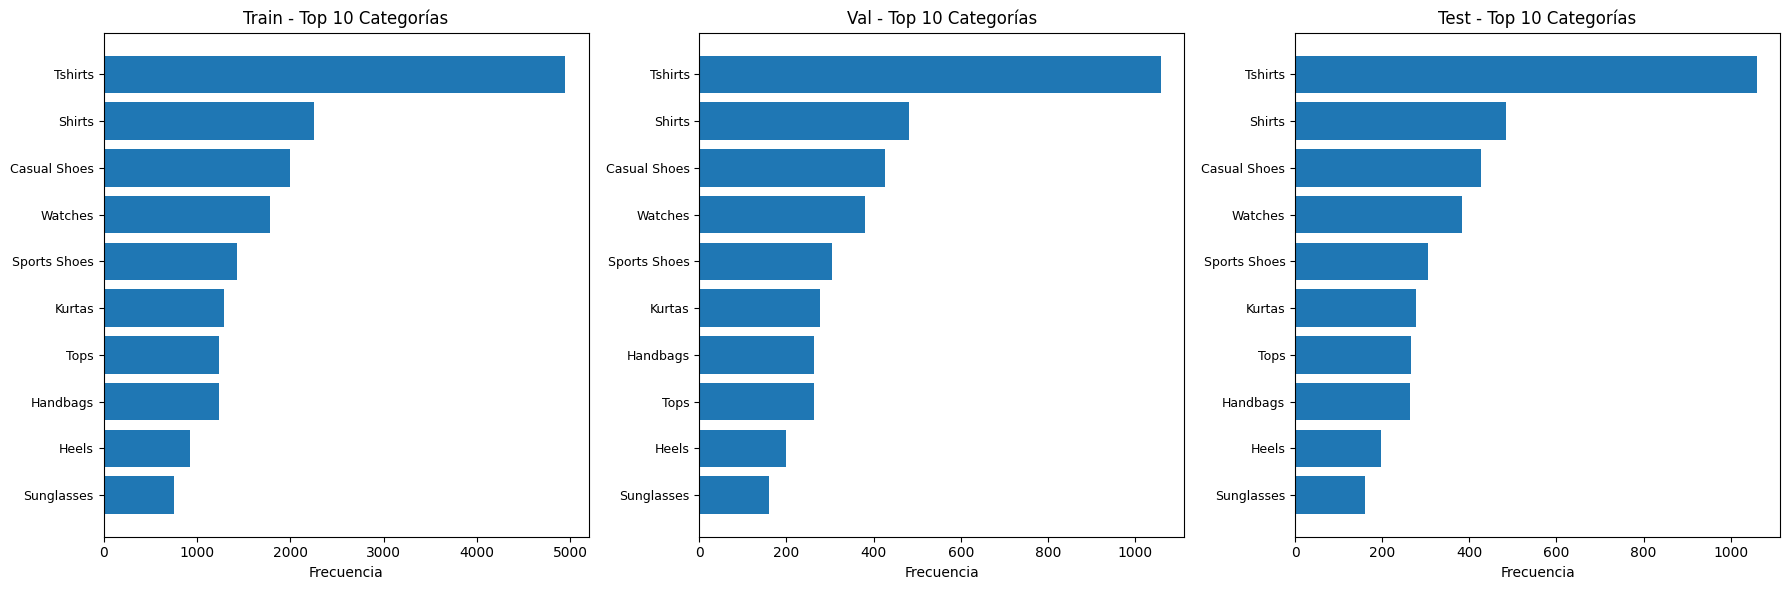

In [2]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ============================================
# CONFIGURACIÓN
# ============================================

# Detectar entorno
IS_KAGGLE = os.path.exists('/kaggle/input')
IS_COLAB = 'COLAB_GPU' in os.environ

print("=" * 60)
print("  RONDA 1 - CREAR SPLITS TRAIN/VAL/TEST")
print("=" * 60)
print(f"\nEntorno: {'Kaggle' if IS_KAGGLE else 'Colab' if IS_COLAB else 'Local'}")

# Rutas
if IS_KAGGLE:
    input_dir = Path('/kaggle/working')
    output_dir = Path('/kaggle/working')
elif IS_COLAB:
    input_dir = Path('/content/fashion_processed')
    output_dir = Path('/content/fashion_processed')
else:
    input_dir = Path('./data/processed')
    output_dir = Path('./data/processed')

output_dir.mkdir(parents=True, exist_ok=True)

# Hiperparámetros
TRAIN_SIZE = 0.70
VAL_SIZE = 0.15
TEST_SIZE = 0.15
RANDOM_STATE = 42

assert abs(TRAIN_SIZE + VAL_SIZE + TEST_SIZE - 1.0) < 0.01, "Los tamaños deben sumar 1.0"

# ============================================
# 1. CARGAR DATASET LIMPIO
# ============================================

print("\n[1/5] Cargando dataset limpio...")

csv_path = input_dir / "df_clean.csv"
assert csv_path.exists(), f"❌ No se encontró {csv_path}. Ejecuta script 01 primero."

df = pd.read_csv(csv_path)
print(f"✅ Dataset cargado: {len(df):,} productos")
print(f"📊 Columnas: {df.columns.tolist()}")

# Verificar columnas necesarias
required_cols = ['id', 'gender', 'masterCategory', 'articleType', 'baseColour', 'season', 'usage']
missing_cols = set(required_cols) - set(df.columns)
assert len(missing_cols) == 0, f"❌ Faltan columnas: {missing_cols}"

# ============================================
# 2. ANÁLISIS PRE-SPLIT
# ============================================

print("\n[2/5] Analizando distribución de clases...")

# Contar categorías
print(f"\n📊 Categorías únicas:")
print(f"  - articleType (target principal): {df['articleType'].nunique()} clases")
print(f"  - usage (target secundario): {df['usage'].nunique()} clases")
print(f"  - gender: {df['gender'].nunique()} valores")
print(f"  - masterCategory: {df['masterCategory'].nunique()} categorías")

# Top 10 clases más comunes
print(f"\n🔝 Top 10 articleType más frecuentes:")
top_10 = df['articleType'].value_counts().head(10)
for idx, (category, count) in enumerate(top_10.items(), 1):
    pct = count / len(df) * 100
    print(f"  {idx:2d}. {category:20s}: {count:5,} ({pct:5.2f}%)")

# Detectar clases con muy pocas muestras
min_samples = 3  # Mínimo para poder hacer split
rare_classes = df['articleType'].value_counts()[df['articleType'].value_counts() < min_samples]

if len(rare_classes) > 0:
    print(f"\n⚠️ ADVERTENCIA: {len(rare_classes)} clases con <{min_samples} muestras:")
    for cls, count in rare_classes.items():
        print(f"  - {cls}: {count} muestra(s)")
    print(f"  Estas clases se eliminarán para evitar errores en split estratificado.")

    # Eliminar clases raras
    df = df[~df['articleType'].isin(rare_classes.index)].copy()
    print(f"\n✅ Dataset después de filtrar: {len(df):,} productos")

# ============================================
# 3. CREAR SPLIT TRAIN + TEMP (VAL+TEST)
# ============================================

print("\n[3/5] Creando split Train/Temp...")

# Primer split: Train (70%) vs Temp (30%)
train_df, temp_df = train_test_split(
    df,
    test_size=(VAL_SIZE + TEST_SIZE),
    stratify=df['articleType'],
    random_state=RANDOM_STATE
)

print(f"✅ Train: {len(train_df):,} productos ({len(train_df)/len(df)*100:.2f}%)")
print(f"✅ Temp:  {len(temp_df):,} productos ({len(temp_df)/len(df)*100:.2f}%)")

# Verificar distribución
print(f"\n🔍 Verificación de distribución (top 5 clases):")
for category in df['articleType'].value_counts().head(5).index:
    total = (df['articleType'] == category).sum()
    train_count = (train_df['articleType'] == category).sum()
    temp_count = (temp_df['articleType'] == category).sum()

    print(f"  {category:20s}: Total={total:4d} | Train={train_count:4d} ({train_count/total*100:.1f}%) | Temp={temp_count:4d} ({temp_count/total*100:.1f}%)")

# ============================================
# 4. SPLIT TEMP EN VAL Y TEST
# ============================================

print("\n[4/5] Dividiendo Temp en Val y Test...")

# Detectar clases con muy pocas muestras en temp_df (ahora el mínimo es 2 para el split)
temp_rare_classes = temp_df['articleType'].value_counts()[temp_df['articleType'].value_counts() < 2] # Classes with only 1 sample in temp_df

if len(temp_rare_classes) > 0:
    print(f"\n⚠️ ADVERTENCIA: {len(temp_rare_classes)} clases en Temp con 1 muestra:")
    for cls, count in temp_rare_classes.items():
        print(f"  - {cls}: {count} muestra(s)")
    print(f"  Estas clases se eliminarán de Temp para evitar errores en split estratificado.")
    temp_df = temp_df[~temp_df['articleType'].isin(temp_rare_classes.index)].copy()
    print(f"✅ Temp después de filtrar: {len(temp_df):,} productos")

# Segundo split: Val (50% de Temp) vs Test (50% de Temp)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df['articleType'],
    random_state=RANDOM_STATE
)

print(f"✅ Val:  {len(val_df):,} productos ({len(val_df)/len(df)*100:.2f}%)")
print(f"✅ Test: {len(test_df):,} productos ({len(test_df)/len(df)*100:.2f}%)")

# Verificar que no hay overlap
train_ids = set(train_df['id'])
val_ids = set(val_df['id'])
test_ids = set(test_df['id'])

overlap_train_val = train_ids & val_ids
overlap_train_test = train_ids & test_ids
overlap_val_test = val_ids & test_ids

assert len(overlap_train_val) == 0, f"❌ Overlap entre train y val: {len(overlap_train_val)}"
assert len(overlap_train_test) == 0, f"❌ Overlap entre train y test: {len(overlap_train_test)}"
assert len(overlap_val_test) == 0, f"❌ Overlap entre val y test: {len(overlap_val_test)}"

print(f"\n✅ No hay overlap entre splits")

# ============================================
# 5. VALIDACIÓN DE SPLITS
# ============================================

print("\n[5/5] Validando splits...")

# Verificar que todas las clases importantes estén en cada split
important_classes = df['articleType'].value_counts().head(20).index

missing_in_train = []
missing_in_val = []
missing_in_test = []

for cls in important_classes:
    if cls not in train_df['articleType'].values:
        missing_in_train.append(cls)
    if cls not in val_df['articleType'].values:
        missing_in_val.append(cls)
    if cls not in test_df['articleType'].values:
        missing_in_test.append(cls)

if len(missing_in_train) > 0:
    print(f"⚠️ Clases faltantes en Train: {missing_in_train}")
if len(missing_in_val) > 0:
    print(f"⚠️ Clases faltantes en Val: {missing_in_val}")
if len(missing_in_test) > 0:
    print(f"⚠️ Clases faltantes en Test: {missing_in_test}")

if len(missing_in_train) == 0 and len(missing_in_val) == 0 and len(missing_in_test) == 0:
    print(f"✅ Todas las clases importantes están en cada split")

# Estadísticas por split
print(f"\n📊 Estadísticas por split:")

for name, split_df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    print(f"\n  {name}:")
    print(f"    - Productos: {len(split_df):,}")
    print(f"    - Clases únicas (articleType): {split_df['articleType'].nunique()}")
    print(f"    - Géneros: {split_df['gender'].value_counts().to_dict()}")
    print(f"    - Categorías principales: {split_df['masterCategory'].value_counts().to_dict()}")

# ============================================
# 6. VISUALIZACIÓN
# ============================================

print("\n[6/7] Generando visualización...")

# Comparar distribuciones
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (name, split_df) in enumerate([('Train', train_df), ('Val', val_df), ('Test', test_df)]):
    top_10_split = split_df['articleType'].value_counts().head(10)
    axes[idx].barh(range(len(top_10_split)), top_10_split.values)
    axes[idx].set_yticks(range(len(top_10_split)))
    axes[idx].set_yticklabels(top_10_split.index, fontsize=9)
    axes[idx].set_xlabel('Frecuencia')
    axes[idx].set_title(f'{name} - Top 10 Categorías')
    axes[idx].invert_yaxis()

plt.tight_layout()
viz_path = output_dir / "splits_distribution.png"
plt.savefig(viz_path, dpi=100, bbox_inches='tight')
print(f"✅ Visualización guardada: {viz_path}")

# ============================================
# 7. GUARDAR SPLITS
# ============================================

print("\n[7/7] Guardando splits...")

# Guardar CSVs
train_path = output_dir / "train.csv"
val_path = output_dir / "val.csv"
test_path = output_dir / "test.csv"

train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)

print(f"✅ Train guardado: {train_path} ({len(train_df):,} filas)")
print(f"✅ Val guardado:   {val_path} ({len(val_df):,} filas)")
print(f"✅ Test guardado:  {test_path} ({len(test_df):,} filas)")

# Guardar info de splits
info_path = output_dir / "splits_info.txt"
with open(info_path, 'w') as f:
    f.write("=" * 60 + "\n")
    f.write("  INFORMACIÓN DE SPLITS TRAIN/VAL/TEST\n")
    f.write("=" * 60 + "\n\n")

    f.write("1. CONFIGURACIÓN\n")
    f.write(f"   - Train size: {TRAIN_SIZE*100:.1f}%\n")
    f.write(f"   - Val size: {VAL_SIZE*100:.1f}%\n")
    f.write(f"   - Test size: {TEST_SIZE*100:.1f}%\n")
    f.write(f"   - Random state: {RANDOM_STATE}\n")
    f.write(f"   - Estratificación: articleType\n\n")

    f.write("2. TAMAÑOS REALES\n")
    f.write(f"   - Dataset total: {len(df):,} productos\n")
    f.write(f"   - Train: {len(train_df):,} ({len(train_df)/len(df)*100:.2f}%)\n")
    f.write(f"   - Val: {len(val_df):,} ({len(val_df)/len(df)*100:.2f}%)\n")
    f.write(f"   - Test: {len(test_df):,} ({len(test_df)/len(df)*100:.2f}%)\n\n")

    f.write("3. CLASES POR SPLIT\n")
    f.write(f"   - Train: {train_df['articleType'].nunique()} clases únicas\n")
    f.write(f"   - Val: {val_df['articleType'].nunique()} clases únicas\n")
    f.write(f"   - Test: {test_df['articleType'].nunique()} clases únicas\n\n")

    f.write("4. TOP 10 CATEGORÍAS (articleType)\n")
    for rank, (category, count) in enumerate(df['articleType'].value_counts().head(10).items(), 1):
        train_c = (train_df['articleType'] == category).sum()
        val_c = (val_df['articleType'] == category).sum()
        test_c = (test_df['articleType'] == category).sum()
        f.write(f"   {rank:2d}. {category:25s}: Total={count:5,} | Train={train_c:4,} | Val={val_c:4,} | Test={test_c:4,}\n")

    f.write("\n5. DISTRIBUCIÓN DE GÉNEROS\n")
    for gender in df['gender'].unique():
        total_g = (df['gender'] == gender).sum()
        train_g = (train_df['gender'] == gender).sum()
        val_g = (val_df['gender'] == gender).sum()
        test_g = (test_df['gender'] == gender).sum()
        f.write(f"   - {gender:10s}: Total={total_g:5,} | Train={train_g:4,} | Val={val_g:4,} | Test={test_g:4,}\n")

    f.write("\n6. ARCHIVOS GENERADOS\n")
    f.write(f"   - {train_path.name}\n")
    f.write(f"   - {val_path.name}\n")
    f.write(f"   - {test_path.name}\n")
    f.write(f"   - {viz_path.name}\n")

print(f"✅ Información guardada: {info_path}")

# ============================================
# 8. RESUMEN FINAL
# ============================================

print("\n" + "=" * 60)
print("  SPLITS CREADOS EXITOSAMENTE")
print("=" * 60)
print(f"\n📊 RESUMEN:")
print(f"  - Dataset total: {len(df):,} productos")
print(f"  - Train: {len(train_df):,} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  - Val: {len(val_df):,} ({len(val_df)/len(df)*100:.1f}%)")
print(f"  - Test: {len(test_df):,} ({len(test_df)/len(df)*100:.1f}%)")
print(f"\n📁 Archivos generados:")
print(f"  - {train_path}")
print(f"  - {val_path}")
print(f"  - {test_path}")
print(f"  - {info_path}")
print(f"  - {viz_path}")
print(f"\n✅ Listo para entrenar modelos! (Ronda 2)")
print("=" * 60)


  RONDA 1 - VERIFICACIÓN FINAL DEL DATASET

Entorno: Kaggle

[1/6] Cargando splits...
✅ Train: 31,083 productos
✅ Val:   6,655 productos
✅ Test:  6,655 productos
✅ Total: 44,393 productos

[2/6] Verificando overlap entre splits...
✅ No hay overlap entre splits

[3/6] Verificando existencia de imágenes...


Verificando Train:   0%|          | 0/31083 [00:00<?, ?it/s]


  Train:
    - Total: 31,083
    - Faltantes: 0
    - Corruptas: 0


Verificando Val:   0%|          | 0/6655 [00:00<?, ?it/s]


  Val:
    - Total: 6,655
    - Faltantes: 0
    - Corruptas: 0


Verificando Test:   0%|          | 0/6655 [00:00<?, ?it/s]


  Test:
    - Total: 6,655
    - Faltantes: 0
    - Corruptas: 0

✅ Todas las imágenes existen y son válidas!

[4/6] Analizando distribución de clases...

📊 Top 10 categorías por split:

  Train:
     1. Tshirts                  : 4,946 (15.91%)
     2. Shirts                   : 2,250 ( 7.24%)
     3. Casual Shoes             : 1,991 ( 6.41%)
     4. Watches                  : 1,779 ( 5.72%)
     5. Sports Shoes             : 1,425 ( 4.58%)
     6. Kurtas                   : 1,291 ( 4.15%)
     7. Tops                     : 1,233 ( 3.97%)
     8. Handbags                 : 1,231 ( 3.96%)
     9. Heels                    :  926 ( 2.98%)
    10. Sunglasses               :  751 ( 2.42%)

  Val:
     1. Tshirts                  : 1,060 (15.93%)
     2. Shirts                   :  482 ( 7.24%)
     3. Casual Shoes             :  427 ( 6.42%)
     4. Watches                  :  381 ( 5.73%)
     5. Sports Shoes             :  305 ( 4.58%)
     6. Kurtas                   :  276 ( 4.15%)
  

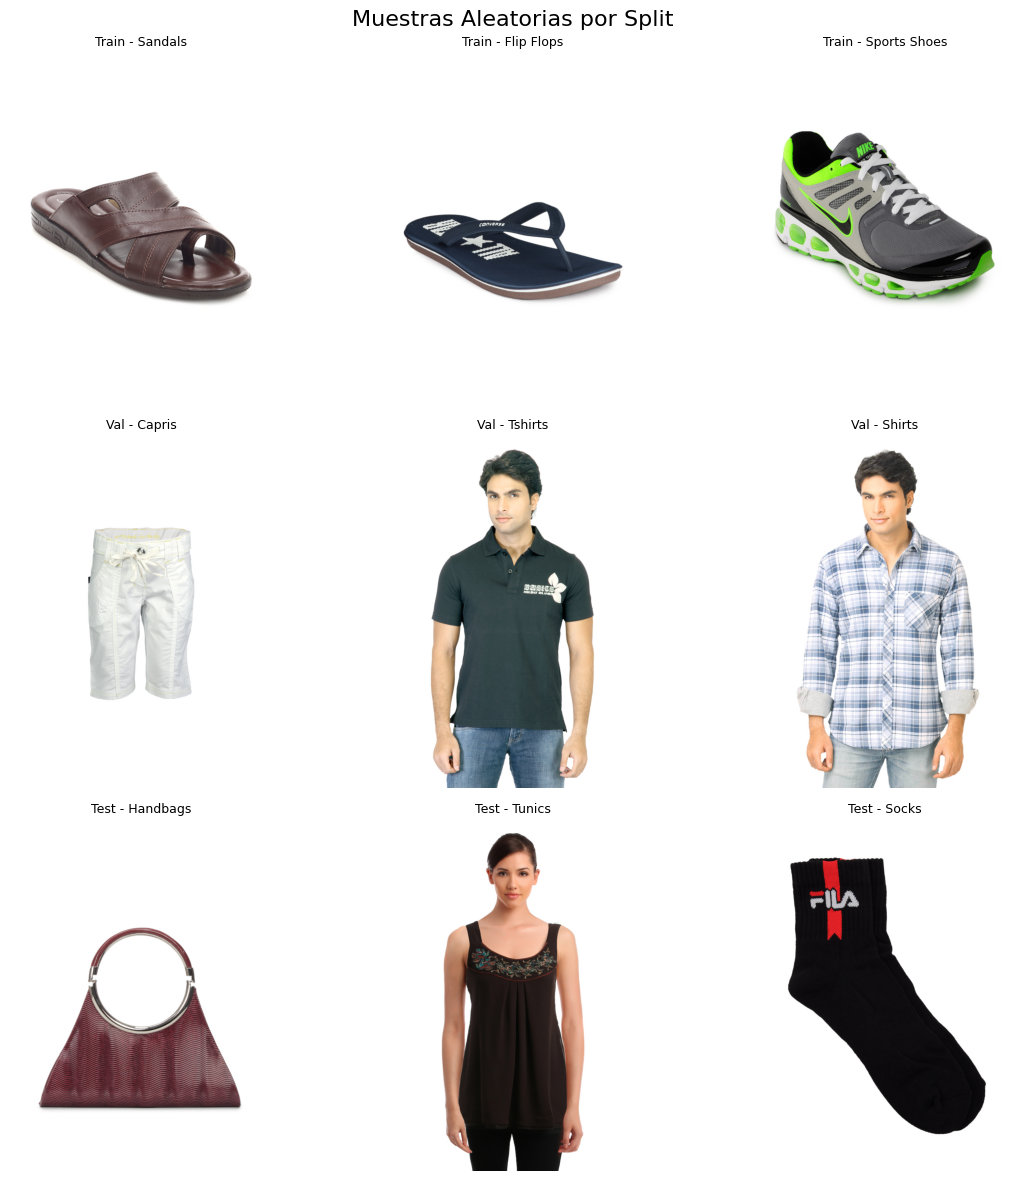

In [3]:
"""
RONDA 1 - SCRIPT 3: Verificación Final del Dataset
===================================================

Propósito:
- Verificar integridad de splits antes de entrenar
- Validar que las imágenes de cada split existen y son accesibles
- Generar estadísticas detalladas para documentación

Uso:
  - Ejecutar después de 02_create_train_val_test_splits.py
  - GPU: No necesaria
  - Tiempo estimado: 2-3 minutos

Inputs (requiere):
  - train.csv
  - val.csv
  - test.csv
  - Carpeta de imágenes

Outputs:
  - verification_report.txt
  - sample_images_per_split.png

Autor: similarPic Team
Fecha: 2025-11
"""

import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import random
import warnings
warnings.filterwarnings('ignore')

# ============================================
# CONFIGURACIÓN
# ============================================

IS_KAGGLE = os.path.exists('/kaggle/input')
IS_COLAB = 'COLAB_GPU' in os.environ

print("=" * 60)
print("  RONDA 1 - VERIFICACIÓN FINAL DEL DATASET")
print("=" * 60)
print(f"\nEntorno: {'Kaggle' if IS_KAGGLE else 'Colab' if IS_COLAB else 'Local'}")

# Rutas
if IS_KAGGLE:
    base_path = Path('/kaggle/input/fashion-product-images-dataset/fashion-dataset')
    if not base_path.exists():
        base_path = Path('/kaggle/input/fashion-product-images-dataset')
    input_dir = Path('/kaggle/working')
    output_dir = Path('/kaggle/working')
elif IS_COLAB:
    # Descargar dataset si no está
    try:
        import kagglehub
    except:
        os.system("pip install kagglehub --quiet")
        import kagglehub

    path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")
    base_path = Path(path) / "fashion-dataset"
    if not base_path.exists():
        base_path = Path(path)
    input_dir = Path('/content/fashion_processed')
    output_dir = Path('/content/fashion_processed')
else:
    base_path = Path('./data/raw')
    input_dir = Path('./data/processed')
    output_dir = Path('./data/processed')

images_path = base_path / "images"
output_dir.mkdir(parents=True, exist_ok=True)

random.seed(42)

# ============================================
# 1. CARGAR SPLITS
# ============================================

print("\n[1/6] Cargando splits...")

train_path = input_dir / "train.csv"
val_path = input_dir / "val.csv"
test_path = input_dir / "test.csv"

# Verificar existencia
for path in [train_path, val_path, test_path]:
    assert path.exists(), f"❌ No se encontró {path}. Ejecuta scripts 01 y 02 primero."

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

print(f"✅ Train: {len(train_df):,} productos")
print(f"✅ Val:   {len(val_df):,} productos")
print(f"✅ Test:  {len(test_df):,} productos")
print(f"✅ Total: {len(train_df) + len(val_df) + len(test_df):,} productos")

# ============================================
# 2. VERIFICAR NO HAY OVERLAP
# ============================================

print("\n[2/6] Verificando overlap entre splits...")

train_ids = set(train_df['id'].astype(str))
val_ids = set(val_df['id'].astype(str))
test_ids = set(test_df['id'].astype(str))

overlap_train_val = train_ids & val_ids
overlap_train_test = train_ids & test_ids
overlap_val_test = val_ids & test_ids

if len(overlap_train_val) == 0 and len(overlap_train_test) == 0 and len(overlap_val_test) == 0:
    print(f"✅ No hay overlap entre splits")
else:
    print(f"❌ PROBLEMA: Hay overlap!")
    if len(overlap_train_val) > 0:
        print(f"  - Train-Val: {len(overlap_train_val)} productos")
    if len(overlap_train_test) > 0:
        print(f"  - Train-Test: {len(overlap_train_test)} productos")
    if len(overlap_val_test) > 0:
        print(f"  - Val-Test: {len(overlap_val_test)} productos")

# ============================================
# 3. VERIFICAR EXISTENCIA DE IMÁGENES
# ============================================

print("\n[3/6] Verificando existencia de imágenes...")

def check_images(df, split_name):
    """Verificar que las imágenes existan para un split"""
    missing = []
    corrupted = []

    for idx, row in tqdm(df.iterrows(), total=len(df), desc=f"Verificando {split_name}"):
        img_id = str(row['id'])
        img_path = images_path / f"{img_id}.jpg"

        if not img_path.exists():
            missing.append(img_id)
        else:
            try:
                with Image.open(img_path) as img:
                    img.verify()
            except Exception as e:
                corrupted.append((img_id, str(e)))

    return missing, corrupted

# Verificar cada split
results = {}
for split_name, split_df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    missing, corrupted = check_images(split_df, split_name)
    results[split_name] = {'missing': missing, 'corrupted': corrupted}

    print(f"\n  {split_name}:")
    print(f"    - Total: {len(split_df):,}")
    print(f"    - Faltantes: {len(missing)}")
    print(f"    - Corruptas: {len(corrupted)}")

    if len(missing) > 0:
        print(f"    ⚠️ Imágenes faltantes: {missing[:5]}")
    if len(corrupted) > 0:
        print(f"    ⚠️ Imágenes corruptas: {[c[0] for c in corrupted[:5]]}")

total_issues = sum(len(r['missing']) + len(r['corrupted']) for r in results.values())
if total_issues == 0:
    print(f"\n✅ Todas las imágenes existen y son válidas!")
else:
    print(f"\n⚠️ Se encontraron {total_issues} problemas en las imágenes")

# ============================================
# 4. VERIFICAR DISTRIBUCIÓN DE CLASES
# ============================================

print("\n[4/6] Analizando distribución de clases...")

# Top 10 clases en cada split
print(f"\n📊 Top 10 categorías por split:")

for split_name, split_df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    print(f"\n  {split_name}:")
    top_10 = split_df['articleType'].value_counts().head(10)
    for rank, (category, count) in enumerate(top_10.items(), 1):
        pct = count / len(split_df) * 100
        print(f"    {rank:2d}. {category:25s}: {count:4,} ({pct:5.2f}%)")

# Verificar que las clases importantes estén en todos los splits
all_classes = set(train_df['articleType'].unique()) | set(val_df['articleType'].unique()) | set(test_df['articleType'].unique())
train_classes = set(train_df['articleType'].unique())
val_classes = set(val_df['articleType'].unique())
test_classes = set(test_df['articleType'].unique())

only_in_train = train_classes - val_classes - test_classes
only_in_val = val_classes - train_classes - test_classes
only_in_test = test_classes - train_classes - val_classes

print(f"\n🔍 Clases exclusivas:")
print(f"  - Solo en Train: {len(only_in_train)}")
print(f"  - Solo en Val: {len(only_in_val)}")
print(f"  - Solo en Test: {len(only_in_test)}")

if len(only_in_val) > 0 or len(only_in_test) > 0:
    print(f"  ⚠️ Hay clases que no están en Train! Esto puede causar problemas.")

# ============================================
# 5. GENERAR VISUALIZACIÓN
# ============================================

print("\n[5/6] Generando visualización de muestras...")

# Mostrar 3 ejemplos aleatorios de cada split
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.suptitle('Muestras Aleatorias por Split', fontsize=16)

for row_idx, (split_name, split_df) in enumerate([('Train', train_df), ('Val', val_df), ('Test', test_df)]):
    samples = split_df.sample(n=3, random_state=42)

    for col_idx, (_, row) in enumerate(samples.iterrows()):
        img_path = images_path / f"{row['id']}.jpg"

        try:
            img = Image.open(img_path).convert('RGB')
            axes[row_idx, col_idx].imshow(img)
            axes[row_idx, col_idx].set_title(f"{split_name} - {row['articleType']}", fontsize=9)
            axes[row_idx, col_idx].axis('off')
        except Exception as e:
            axes[row_idx, col_idx].text(0.5, 0.5, f"Error: {str(e)[:20]}", ha='center', va='center')
            axes[row_idx, col_idx].axis('off')

plt.tight_layout()
viz_path = output_dir / "sample_images_per_split.png"
plt.savefig(viz_path, dpi=100, bbox_inches='tight')
print(f"✅ Visualización guardada: {viz_path}")

# ============================================
# 6. GENERAR REPORTE FINAL
# ============================================

print("\n[6/6] Generando reporte final...")

report_path = output_dir / "verification_report.txt"
with open(report_path, 'w') as f:
    f.write("=" * 70 + "\n")
    f.write("  REPORTE DE VERIFICACIÓN DEL DATASET\n")
    f.write("=" * 70 + "\n\n")

    f.write("1. INFORMACIÓN GENERAL\n")
    f.write(f"   - Total productos: {len(train_df) + len(val_df) + len(test_df):,}\n")
    f.write(f"   - Train: {len(train_df):,} ({len(train_df)/(len(train_df)+len(val_df)+len(test_df))*100:.2f}%)\n")
    f.write(f"   - Val: {len(val_df):,} ({len(val_df)/(len(train_df)+len(val_df)+len(test_df))*100:.2f}%)\n")
    f.write(f"   - Test: {len(test_df):,} ({len(test_df)/(len(train_df)+len(val_df)+len(test_df))*100:.2f}%)\n\n")

    f.write("2. VERIFICACIÓN DE OVERLAP\n")
    if total_issues == 0:
        f.write("   ✅ No hay overlap entre splits\n\n")
    else:
        f.write(f"   ❌ Se encontraron {total_issues} problemas\n")
        if len(overlap_train_val) > 0:
            f.write(f"   - Train-Val: {len(overlap_train_val)} productos\n")
        if len(overlap_train_test) > 0:
            f.write(f"   - Train-Test: {len(overlap_train_test)} productos\n")
        if len(overlap_val_test) > 0:
            f.write(f"   - Val-Test: {len(overlap_val_test)} productos\n")
        f.write("\n")

    f.write("3. VERIFICACIÓN DE IMÁGENES\n")
    for split_name, result in results.items():
        f.write(f"   {split_name}:\n")
        f.write(f"     - Imágenes faltantes: {len(result['missing'])}\n")
        f.write(f"     - Imágenes corruptas: {len(result['corrupted'])}\n")
        if len(result['missing']) > 0:
            f.write(f"     - Ejemplos faltantes: {result['missing'][:5]}\n")
        if len(result['corrupted']) > 0:
            f.write(f"     - Ejemplos corruptas: {[c[0] for c in result['corrupted'][:5]]}\n")
    f.write("\n")

    f.write("4. DISTRIBUCIÓN DE CLASES (articleType)\n")
    f.write(f"   - Total clases únicas: {len(all_classes)}\n")
    f.write(f"   - Clases en Train: {len(train_classes)}\n")
    f.write(f"   - Clases en Val: {len(val_classes)}\n")
    f.write(f"   - Clases en Test: {len(test_classes)}\n")
    f.write(f"   - Clases solo en Train: {len(only_in_train)}\n")
    f.write(f"   - Clases solo en Val: {len(only_in_val)}\n")
    f.write(f"   - Clases solo en Test: {len(only_in_test)}\n\n")

    f.write("5. TOP 10 CATEGORÍAS GLOBALES\n")
    all_data = pd.concat([train_df, val_df, test_df])
    for rank, (category, count) in enumerate(all_data['articleType'].value_counts().head(10).items(), 1):
        train_c = (train_df['articleType'] == category).sum()
        val_c = (val_df['articleType'] == category).sum()
        test_c = (test_df['articleType'] == category).sum()
        f.write(f"   {rank:2d}. {category:30s}: Total={count:5,} | Train={train_c:4,} | Val={val_c:4,} | Test={test_c:4,}\n")

    f.write("\n6. ESTADÍSTICAS POR VARIABLE\n")
    for var in ['gender', 'masterCategory', 'usage', 'season']:
        f.write(f"\n   {var}:\n")
        for value in all_data[var].value_counts().head(5).index:
            total_v = (all_data[var] == value).sum()
            train_v = (train_df[var] == value).sum()
            val_v = (val_df[var] == value).sum()
            test_v = (test_df[var] == value).sum()
            f.write(f"     - {value:20s}: Total={total_v:5,} | Train={train_v:4,} | Val={val_v:4,} | Test={test_v:4,}\n")

    f.write("\n7. CONCLUSIÓN\n")
    if total_issues == 0 and len(overlap_train_val) == 0 and len(overlap_train_test) == 0 and len(overlap_val_test) == 0:
        f.write("   ✅ Dataset verificado exitosamente\n")
        f.write("   ✅ Listo para entrenamiento de modelos\n")
    else:
        f.write("   ⚠️ Se encontraron algunos problemas\n")
        f.write("   ⚠️ Revisar y corregir antes de entrenar\n")

print(f"✅ Reporte guardado: {report_path}")

# ============================================
# 7. RESUMEN FINAL
# ============================================

print("\n" + "=" * 60)
print("  VERIFICACIÓN COMPLETADA")
print("=" * 60)
print(f"\n✅ Splits verificados:")
print(f"  - Train: {len(train_df):,} productos")
print(f"  - Val: {len(val_df):,} productos")
print(f"  - Test: {len(test_df):,} productos")

if total_issues == 0 and len(overlap_train_val) == 0:
    print(f"\n✅ Dataset listo para entrenamiento!")
    print(f"\n📋 Próximo paso: Ronda 2 - Entrenar Clasificador de Categoría")
else:
    print(f"\n⚠️ Revisar problemas antes de continuar")

print(f"\n📁 Archivos generados:")
print(f"  - {report_path}")
print(f"  - {viz_path}")
print("=" * 60)
